# **PyTorch** 실습

- **Pytorch** 의 bulit-in module을 사용해 간단한 신경망 모델을 정의
- **Pytorch** 의 bulit-in dataset을 사용해 신경망 모델 학습

In [12]:
import torch

In [4]:
torch.__version__

'1.8.0.dev20201207+cu101'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataset: **CIFAR10**

- 실습을 위해 **torchvision** 에서 간단히 불러올 수 있는 dataset인 **CIFAR10**을 사용하겠습니다.
- 아래 그림처럼 10개의 class로 구분된 영상들로 이루어진 dataset입니다.
- **CIFAR10**에 대한 자세한 설명이나 **torchvision**에서 사용할 수 있는 bulit-in dataset들을 아래 링크에서 확인할 수 있습니다.
> **CIFAR10**: https://www.cs.toronto.edu/~kriz/cifar.html  
> **torchvision.datasets**: https://pytorch.org/docs/stable/torchvision/datasets.html

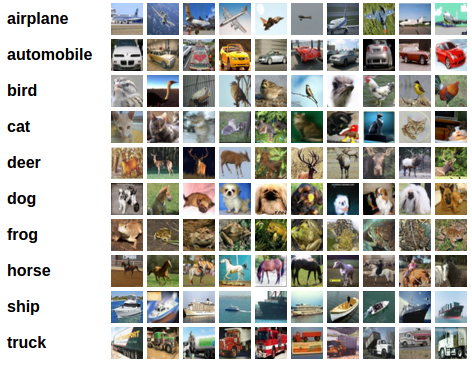

## 1. **CIFAR10** 데이터 불러오고 정규화하기

In [98]:
import torchvision
import torchvision.transforms as transforms

In [99]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

In [101]:
data_dir = './data'

image_datasets = {x: torchvision.datasets.CIFAR10(root=data_dir, train=(x=='train'),
                                        download=True, transform=data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes


# valset, testset = torch.utils.data.random_split(testset, [len(testset)//2, len(testset)-len(testset)//2])

Files already downloaded and verified
Files already downloaded and verified


## 2. 데이터 살펴보기

In [102]:
import matplotlib.pyplot as plt
import numpy as np

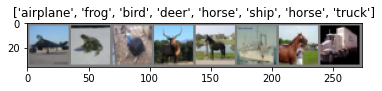

In [104]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 3. 첫번째 simple CNN 모델 정의하기

In [105]:
import torch.nn as nn
import torch.nn.functional as F

In [106]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 4. Loss function과 Optimizer 정의하기

In [107]:
import torch.optim as optim

In [109]:
model_ft = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 lr 감소
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 5. 신경망 모델 학습하기

In [116]:
from tqdm import tqdm
import time
import copy

In [119]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [120]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 0/1250 [00:00<?, ?it/s]

train Loss: 1.5625 Acc: 0.4308


  0%|          | 0/6250 [00:00<?, ?it/s]

val Loss: 1.4010 Acc: 0.4852

Epoch 1/4
----------


  0%|          | 0/1250 [00:00<?, ?it/s]

train Loss: 1.3425 Acc: 0.5175


  0%|          | 0/6250 [00:00<?, ?it/s]

val Loss: 1.2845 Acc: 0.5383

Epoch 2/4
----------


  0%|          | 0/1250 [00:00<?, ?it/s]

train Loss: 1.2202 Acc: 0.5660


  0%|          | 0/6250 [00:00<?, ?it/s]

val Loss: 1.1681 Acc: 0.5848

Epoch 3/4
----------


  0%|          | 0/1250 [00:00<?, ?it/s]

train Loss: 1.1347 Acc: 0.5972


  0%|          | 0/6250 [00:00<?, ?it/s]

val Loss: 1.1437 Acc: 0.5992

Epoch 4/4
----------


  0%|          | 0/1250 [00:00<?, ?it/s]

train Loss: 1.0720 Acc: 0.6209


100%|██████████| 1250/1250 [00:03<00:00, 366.62it/s]

val Loss: 1.0802 Acc: 0.6181

Training complete in 2m 25s
Best val Acc: 0.618100


## 6. 결과 확인

In [123]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('label: {} , predicted: {}'.format(class_names[labels.cpu().data[j]], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

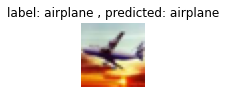

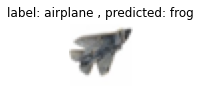

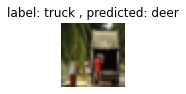

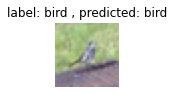

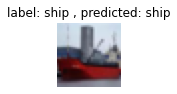

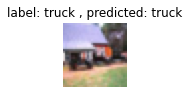

In [124]:
visualize_model(model_ft)

## 7. 두 번째 VGG16 모델

In [143]:
import torchvision.models as models

In [144]:
model_ft = models.vgg16(pretrained=True)
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [145]:
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, 10)
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [148]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

  0%|          | 0/6250 [00:00<?, ?it/s]

Epoch 0/4
----------


  0%|          | 0/1250 [00:00<?, ?it/s]

train Loss: 0.8825 Acc: 0.6902


  0%|          | 0/6250 [00:00<?, ?it/s]

val Loss: 1.0031 Acc: 0.6560

Epoch 1/4
----------


  0%|          | 0/1250 [00:00<?, ?it/s]

train Loss: 0.8576 Acc: 0.7004


  0%|          | 0/6250 [00:00<?, ?it/s]

val Loss: 0.9973 Acc: 0.6607

Epoch 2/4
----------


  0%|          | 0/1250 [00:00<?, ?it/s]

train Loss: 0.8352 Acc: 0.7067


  0%|          | 0/6250 [00:00<?, ?it/s]

val Loss: 0.9773 Acc: 0.6690

Epoch 3/4
----------


  0%|          | 0/1250 [00:00<?, ?it/s]

train Loss: 0.8144 Acc: 0.7125


  0%|          | 0/6250 [00:00<?, ?it/s]

val Loss: 0.9772 Acc: 0.6634

Epoch 4/4
----------


  0%|          | 0/1250 [00:00<?, ?it/s]

train Loss: 0.7985 Acc: 0.7184


100%|██████████| 1250/1250 [00:03<00:00, 327.07it/s]

val Loss: 0.9869 Acc: 0.6595

Training complete in 2m 42s
Best val Acc: 0.669000
